In [1]:
import pandas as pd
from data_processing import *
from utils import *
from modeling import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


In [ ]:
df = pd.read_csv('Data/panel.csv')



,Unnamed: 0,year,month,tokens,obs,sentiment_words,uncertainty,ste_theta0,ste_theta1,ste_theta2,...,civilwar1,contig_anyviolence,childmortality,populationwb,democracy0,democracy1,democracy2,democracy3,democracy4,democracy5
0,0,1989,1,35484.0,242.0,1501.7950,6.0,0.116674,0.064620,0.112124,...,0.0,1.0,183.8,11868877.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1989,2,59247.0,318.0,3028.5050,12.0,0.119341,0.069172,0.079474,...,1.0,0.0,183.8,11868877.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2,1989,3,38694.0,229.0,1642.9800,4.0,0.094843,0.051376,0.072050,...,0.0,1.0,183.8,11868877.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,1989,4,31875.0,193.0,1131.9410,2.0,0.097522,0.067324,0.069265,...,0.0,1.0,183.8,11868877.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4,1989,5,18180.0,118.0,739.4256,1.0,0.098442,0.065014,0.083056,...,0.0,1.0,183.8,11868877.0,0.0,1.0,0.0,0.0,0.0,0.0


In [30]:
#load config
config = load_config("config.yaml")

#access config values
lag_type = config['lag_type']
base_covariates = config['base_covariates']
path_out = config['path_out']
end_period = config['end_period']
outcome_variable = config['outcome_variable']
num_lags = config['num_lags']
n_splits = config['n_splits']
test_size = config['test_size']

#load and preprocess data
panel_df = load_clean_panel_data(config['panel_path'])
pax_df = load_clean_pax_data(config['pax_path'], config['mapping_path'])

#build pax features
pax_df = build_pax_features(pax_df)

#merge data
df = merge_pax_panel_data(pax_df, panel_df)

#impute missing data
clean_df = impute_missing_data(df)

# #feature engineering
# df_with_features = feature_engineering(clean_df, 2)
# df_with_ohe, ohe_list = build_one_hot_dummies(df_with_features)

/Users/amberwalker/DML-for-Panel-Data/data_processing.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.loc[:, 'signed_date'] = pd.to_datetime(clean_df['signed date'])
/Users/amberwalker/DML-for-Panel-Data/data_processing.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.loc[:, 'period'] = clean_df['signed_date'].dt.strftime('%Y%m').astype(int)
/Users/amberwalker/DML-for-Panel-Data/data_processing.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [33]:
# 1. Filter out countries with no peace agreements
# Assuming 'any_agreement' column indicates if a peace agreement is present
countries_with_agreement = clean_df[clean_df['any_agreement'] == 1]['isocode'].unique()
df_filtered = clean_df[clean_df['isocode'].isin(countries_with_agreement)]

# 2. Subset data to the period between January 2005 (200501) and January 2010 (201001)
df_filtered = df_filtered[(df_filtered['period'] >= 200501) & (df_filtered['period'] <= 201001)]

# 3. Set `any_agreement` at random to 1 for 30% of the remaining dataset
# Get random sample indices for 30% of the data
sample_indices = df_filtered.sample(frac=0.3, random_state=42).index

# Set 'any_agreement' to 1 for these random samples
df_filtered.loc[sample_indices, 'any_agreement'] = 1

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5587 entries, 192 to 82258
Data columns (total 91 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          5587 non-null   int64  
 1   year                5587 non-null   int64  
 2   month               5587 non-null   int64  
 3   tokens              5526 non-null   float64
 4   obs                 5526 non-null   float64
 5   sentiment_words     5526 non-null   float64
 6   uncertainty         5526 non-null   float64
 7   ste_theta0          5526 non-null   float64
 8   ste_theta1          5526 non-null   float64
 9   ste_theta2          5526 non-null   float64
 10  ste_theta3          5526 non-null   float64
 11  ste_theta4          5526 non-null   float64
 12  ste_theta5          5526 non-null   float64
 13  ste_theta6          5526 non-null   float64
 14  ste_theta7          5526 non-null   float64
 15  ste_theta8          5526 non-null   float64
 16  ste_thet

In [35]:
#feature engineering
df_with_features = feature_engineering(df_filtered, 2)
df_with_ohe, ohe_list = build_one_hot_dummies(df_with_features)

In [36]:
# Create models from config
model_y = create_model(config['model_y'])
model_t = create_model(config['model_t'])

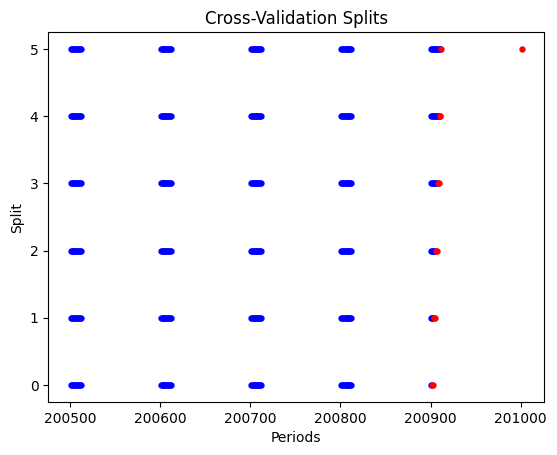

Lag 0 results - Theta: 0.01403799519732393, CI: (0.0061620121271829965, 0.021913978267464863)
Lag 0 done!
{'theta': 0.01403799519732393, 'ci_lower': 0.0061620121271829965, 'ci_upper': 0.021913978267464863, 'neg_mse_avg': -0.00632860948261096, 'auc_avg': 0.5113417899655781}
Lag 1 results - Theta: 0.0047646027904393005, CI: (-0.005261345217696492, 0.014790550798575093)
Lag 1 done!
{'theta': 0.0047646027904393005, 'ci_lower': -0.005261345217696492, 'ci_upper': 0.014790550798575093, 'neg_mse_avg': -0.006280543575008087, 'auc_avg': 0.5291370856910702}
Lag 2 results - Theta: 0.005619624890384096, CI: (-0.0038363308560541614, 0.015075580636822353)
Lag 2 done!
{'theta': 0.005619624890384096, 'ci_lower': -0.0038363308560541614, 'ci_upper': 0.015075580636822353, 'neg_mse_avg': -0.006122379848356973, 'auc_avg': 0.5278545813331601}


In [37]:
# Create X_list based on base_covariates
X_list = [f'{cov}_lag0' for cov in base_covariates]

# Run the prepare_and_run function
X_lagged, T, Y = prepare_and_run(
    df=df_with_ohe,
    end_period=end_period,
    outcome_variable=outcome_variable,
    num_lags=num_lags,
    base_covariates=base_covariates,
    ohe_list=ohe_list,
    n_splits=n_splits,
    test_size=test_size,
    model_y=model_y,
    model_t=model_t,
    path_out=path_out,
    lag_type=lag_type,
    X_list=X_list
)


In [9]:
df = panel_df.merge(pax_df, on=['isocode', 'period'], how='left')

print(pax_df[pax_df['any_agreement'] == 1])

     isocode  period  any_agreement  num_agreements agreement_id
0        AFG  199204              1               1          482
1        AFG  199303              1               1          409
2        AFG  199907              1               1          553
3        AFG  200112              1               1          272
4        AFG  200201              1               1          908
...      ...     ...            ...             ...          ...
1521     ZMB  200612              1               1          668
1522     ZMB  201302              1               1          789
1523     ZWE  200807              1               1          828
1524     ZWE  200809              1               1          826
1525     ZWE  201303              1               1         1340

[1526 rows x 5 columns]
